In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gtsrb-german-traffic-sign/Meta.csv
/kaggle/input/gtsrb-german-traffic-sign/Train.csv
/kaggle/input/gtsrb-german-traffic-sign/Test.csv
/kaggle/input/gtsrb-german-traffic-sign/Meta/37.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/35.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/11.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/31.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/4.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/40.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/33.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/9.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/.~lock.ClassesInformation.ods#
/kaggle/input/gtsrb-german-traffic-sign/Meta/14.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/1.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/39.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/20.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/38.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/2.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/10.png


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.metrics import accuracy_score
from tensorflow import keras
import pathlib
import random as rn
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19, DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
import shutil

In [3]:
classes = { 14:'Stop',  
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only',
            40:'Roundabout mandatory'}

In [4]:
data_dir = '../input/gtsrb-german-traffic-sign/'
train_path = '../input/gtsrb-german-traffic-sign/Train/'
test_path = '../input/gtsrb-german-traffic-sign/Test/'

# Resizing the images to 30x30x3
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3

In [5]:
new_train_path = './new_train/'
if not os.path.exists(new_train_path):
    os.makedirs(new_train_path)
    
# Loop through the desired classes and copy the corresponding images to the new directory
for class_id in classes.keys():
    src_dir = os.path.join(train_path, str(class_id))
    dst_dir = os.path.join(new_train_path, str(class_id))
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    for file_name in os.listdir(src_dir):
        shutil.copy(os.path.join(src_dir, file_name), os.path.join(dst_dir, file_name))


In [6]:
batch_size = 32
seed = 42

In [7]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=10,
                                   zoom_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   fill_mode='nearest',
                                   validation_split=0.2)

# Create image generator from new directory
train_dataset = train_datagen.flow_from_directory(new_train_path,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True,
                                                     seed=seed,
                                                     color_mode='rgb',
                                                     interpolation='hamming',
                                                     subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)
test_dataset = test_datagen.flow_from_directory(new_train_path,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')

Found 2760 images belonging to 5 classes.
Found 689 images belonging to 5 classes.


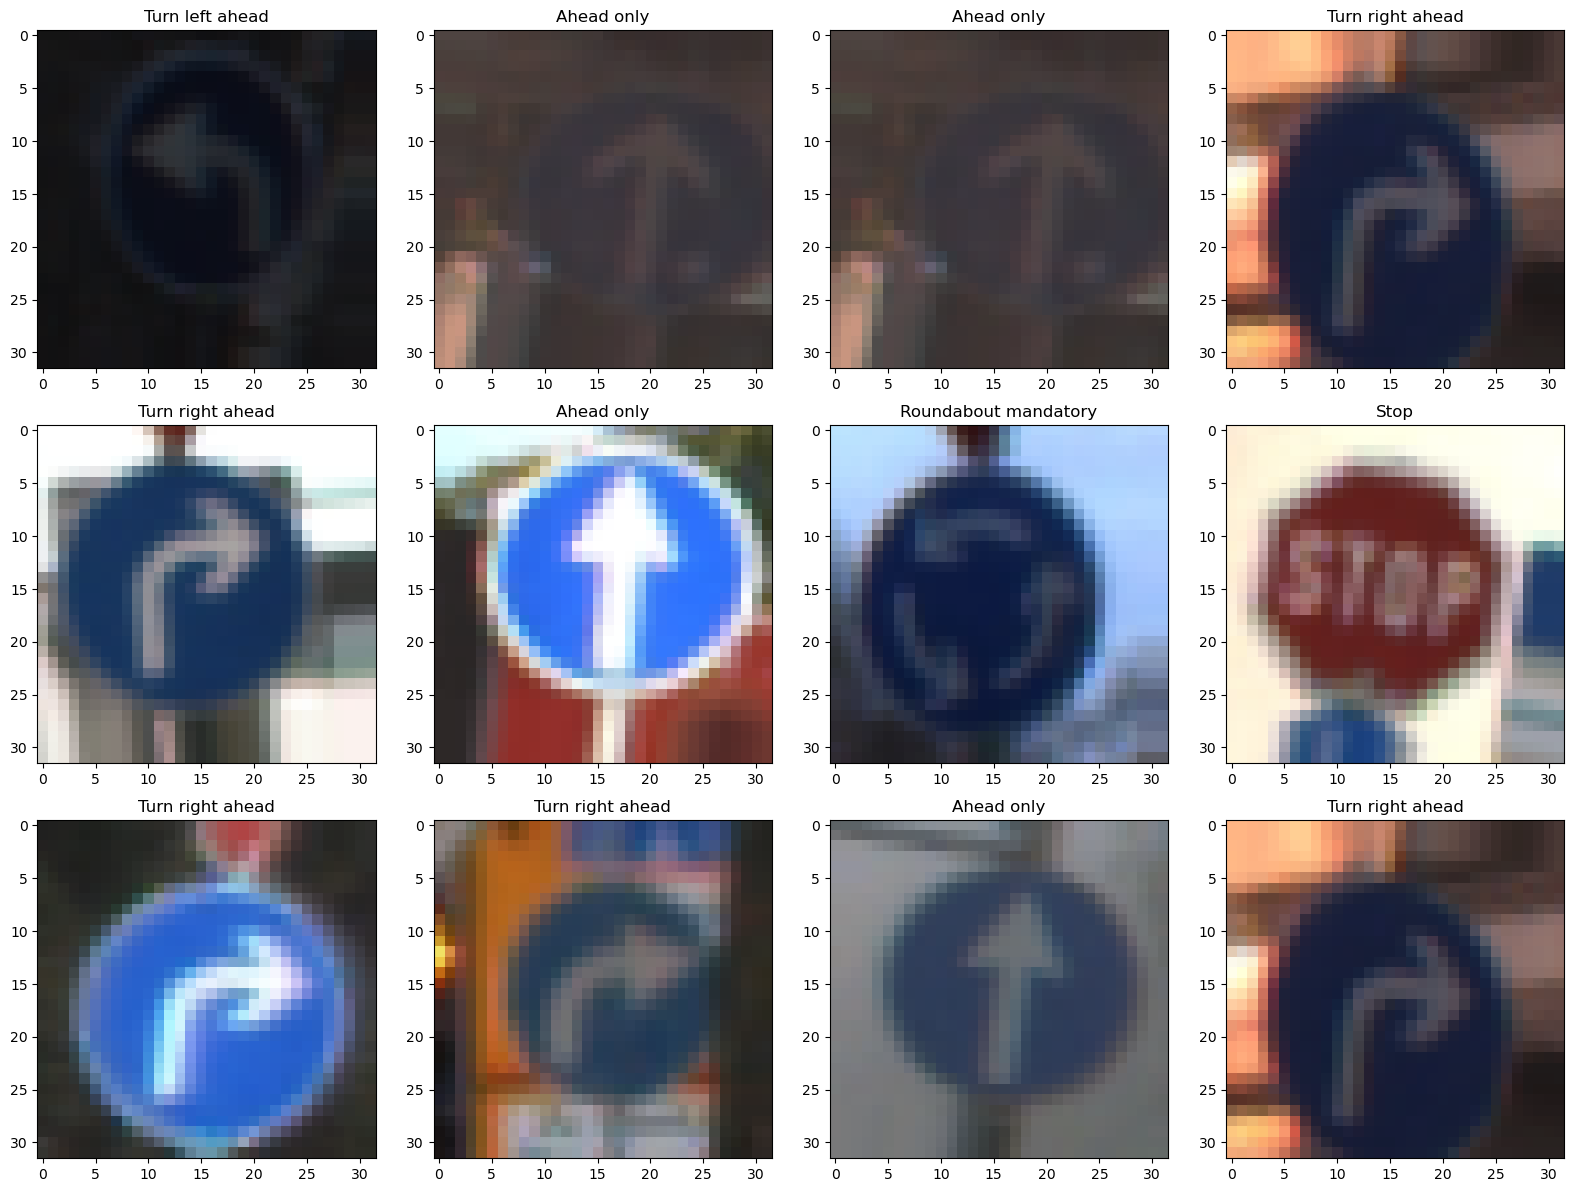

In [8]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
img,y = train_dataset.next()
for i in range(3):
    for j in range (4):
        l=rn.randint(0,batch_size-1)
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[l])])]
        ax[i,j].imshow(img[l])
        ax[i,j].set_title(label)

plt.tight_layout()

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.1))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.1))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(len(classes), activation='softmax'))

In [10]:
vgg_model = tf.keras.Sequential([VGG19(weights='imagenet', include_top=False, input_shape=(32,32,3)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(512, activation='sigmoid'),
                                 keras.layers.Dense(5, activation='softmax')
                                ])

vgg_model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 512)        2048      
 ormalization)                                                   
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 20,291,653
Trainable params: 20,290,629
N

In [11]:
# resnet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(32,32,3))

# for layer in resnet_base.layers:
#     layer.trainable = False

# inputs = Input(shape=(32,32,3))

# # apply the base model to the inputs
# x = resnet_base(inputs)

# # add a GlobalAveragePooling2D layer to reduce the spatial dimensions of the output
# x = GlobalAveragePooling2D()(x)

# # add a Dense layer for classification
# x = Dense(256, activation='relu')(x)

# # add another Dense layer for classification
# x = Dense(128, activation='relu')(x)

# # add the final output layer with softmax activation
# outputs = Dense(5, activation='softmax')(x)


# model = Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
alpha=0.0001
epochs=4
optim = keras.optimizers.Adam(learning_rate=alpha)
vgg_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [12]:
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 512)        2048      
 ormalization)                                                   
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 20,291,653
Trainable params: 20,290,629
Non-trainable params: 1,024
______________________________________

In [13]:
# .fit(train_dataset, epochs=30, steps_per_epoch=len(train_dataset), validation_data=test_dataset, validation_steps=len(test_dataset))

In [14]:
vgg_history = vgg_model.fit(train_dataset,
                        steps_per_epoch=len(train_dataset),
                        epochs=30,
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset))

Epoch 1/30
87/87 [==============================] - 22s 75ms/step - loss: 0.4185 - accuracy: 0.8587 - val_loss: 0.1528 - val_accuracy: 0.9695
Epoch 2/30
87/87 [==============================] - 5s 55ms/step - loss: 0.0439 - accuracy: 0.9899 - val_loss: 0.0658 - val_accuracy: 0.9971
Epoch 3/30
87/87 [==============================] - 5s 57ms/step - loss: 0.0082 - accuracy: 0.9993 - val_loss: 0.1414 - val_accuracy: 0.9594
Epoch 4/30
87/87 [==============================] - 5s 55ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 5/30
87/87 [==============================] - 5s 54ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 6/30
87/87 [==============================] - 5s 57ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 0.9985
Epoch 7/30
87/87 [==============================] - 5s 55ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 9.6884e-04 - val_accuracy: 1.0000
Epoch 8/

In [15]:
def map_pred(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]
test_df = pd.read_csv(data_dir + 'Test.csv')
test_df = test_df[test_df['ClassId'].isin(classes)]
test_df.head()

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
3      27      29       5       5      22      24       33  Test/00003.png
9      81      86       7       7      74      79       35  Test/00009.png
21     52      55       5       6      47      49       33  Test/00021.png
32     53      54       5       6      48      49       34  Test/00032.png
55     34      34       5       6      29      29       35  Test/00055.png

In [16]:
test_labels = test_df["ClassId"].values
imgs = test_df["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((32,32))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

In [17]:
pred = vgg_model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

34/34 [==============================] - 1s 21ms/step
Test Data accuracy:  15.74074074074074


In [18]:
pred2 = model.predict(X_test)
pred2 = map_pred(pred2.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred2)*100)

34/34 [==============================] - 0s 4ms/step
Test Data accuracy:  19.444444444444446


In [19]:
model.save('resnet.h5')

1/1 [==============================] - 0s 23ms/step


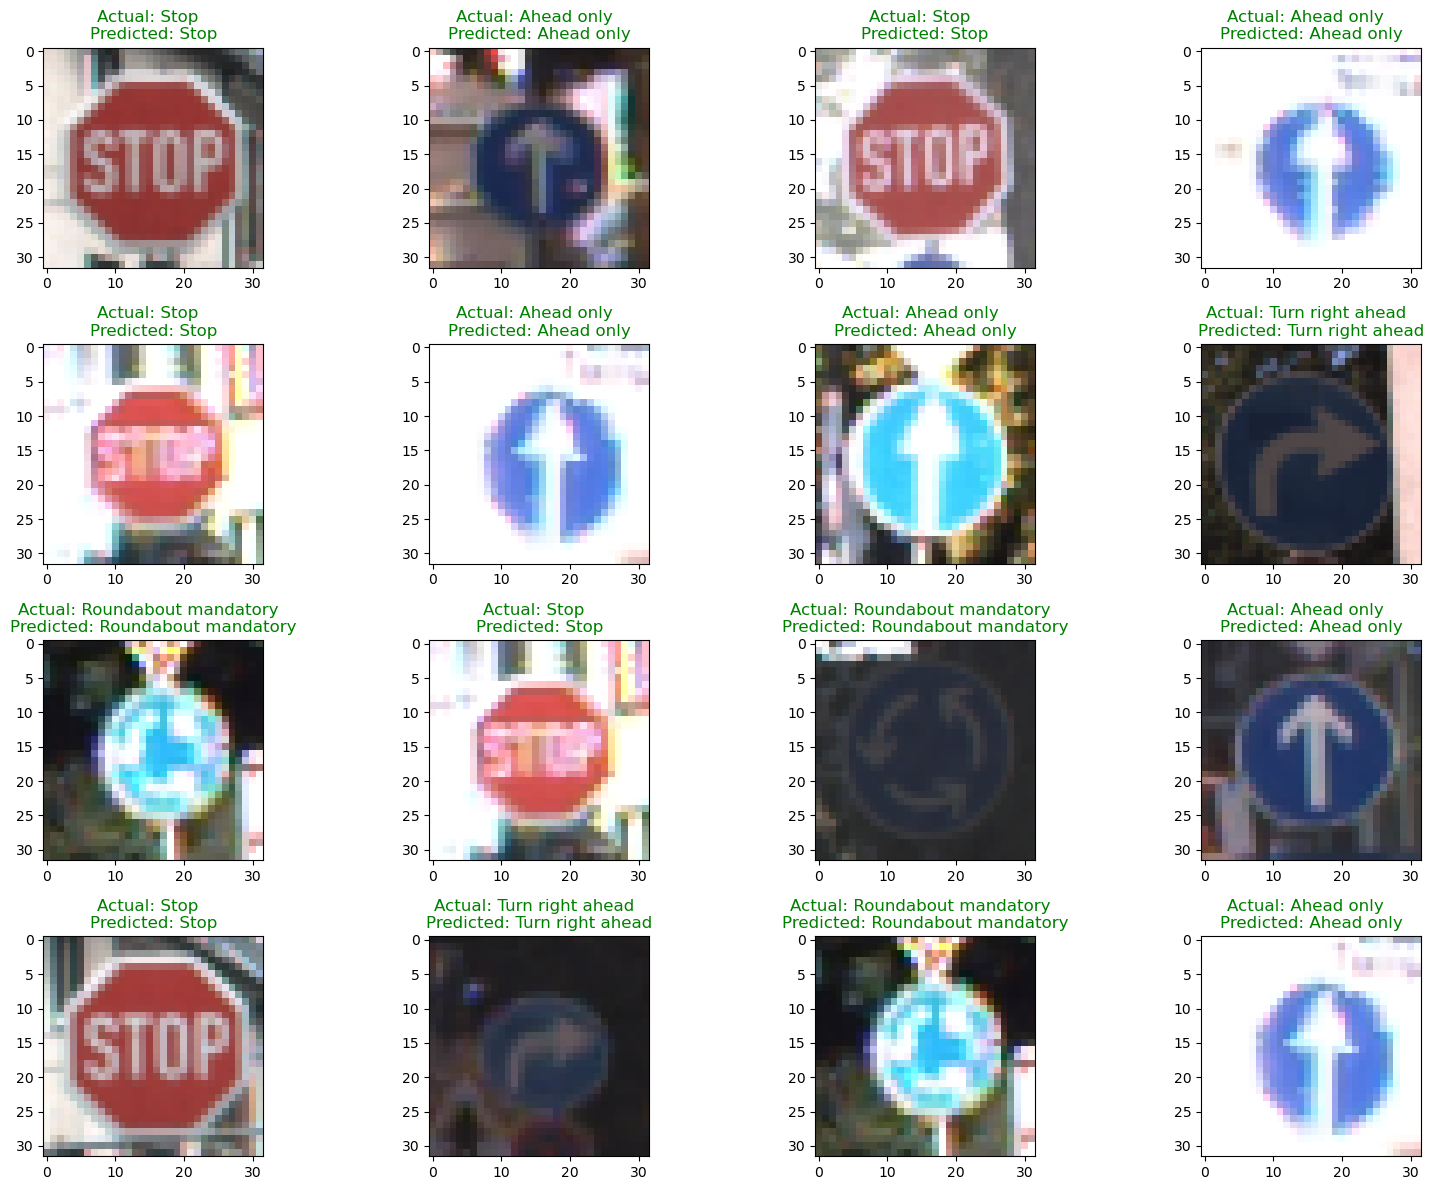

In [20]:
fig,ax=plt.subplots(4,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset.next()
predicted = vgg_model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))
for i in range(4):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else: 
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()